<a href="https://colab.research.google.com/github/anshsharmacse/AI-in-Research-workshop-Hands-On-/blob/main/AI_in_Research_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Section 01 - Import

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

SEED = 42
rng = np.random.default_rng(SEED)

CLASS_START_MIN = 8 * 60
LATE_THRESHOLD = CLASS_START_MIN + 5  # 08:05

WEEKDAYS = ["Mon", "Tue", "Wed", "Thu", "Fri"]

DATASET_PATH = Path("/content/AI in Research Workshop Dataset.csv")
MODEL_PATH = Path("late_mlp_trained_scaled.joblib")

FEATURES = ["wake_time_min", "sleep_start_min", "screen_after_wake_min", "prep_min", "commute_min"]
LABEL = "late"


def min_to_hhmm(m: float) -> str:
    m = int(round(m)) % (24 * 60)
    return f"{m//60:02d}:{m%60:02d}"


def hhmm_to_min(hhmm: str) -> int:
    hhmm = hhmm.strip()
    h, m = hhmm.split(":")
    return int(h) * 60 + int(m)


def clamp(x, lo, hi):
    return max(lo, min(hi, x))


Section 02 - Load Dataset

Shape: (50000, 8)


,day,wake_time_min,sleep_start_min,screen_after_wake_min,prep_min,commute_min,arrival_time_min,late
0,Tue,420,102,14.2,30.9,3.4,463.1,0
1,Fri,496,80,0.0,21.3,24.2,525.3,1
2,Thu,507,1369,0.0,35.4,6.3,549.1,1
3,Wed,380,130,13.8,25.7,22.9,439.8,0
4,Tue,417,12,7.6,37.9,8.9,466.5,0
5,Wed,570,34,3.6,6.0,41.9,618.2,1
6,Mon,362,82,38.6,33.8,4.6,421.1,0
7,Wed,340,36,32.6,21.9,27.7,404.9,0
8,Tue,471,41,9.7,20.9,12.3,513.5,1
9,Fri,270,1290,40.9,27.6,93.1,417.9,0


Late rate (%): 42.63


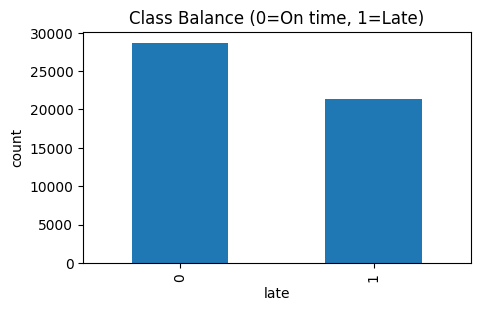

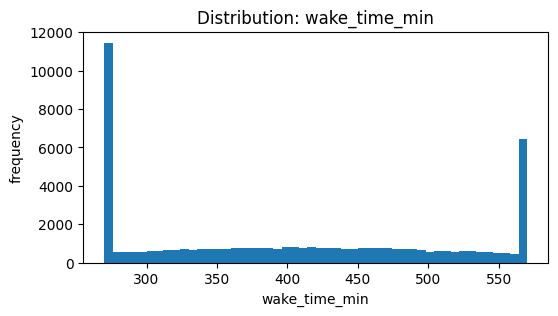

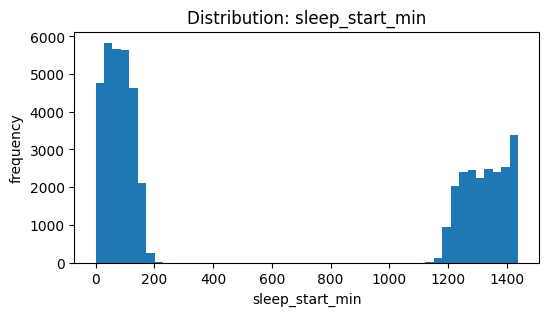

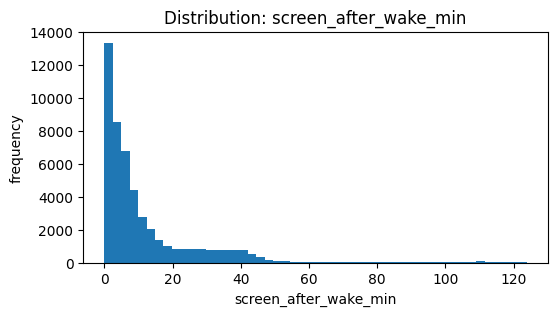

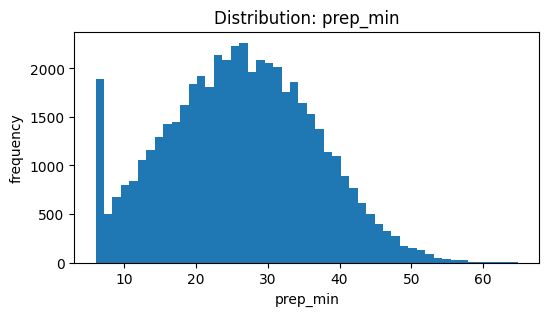

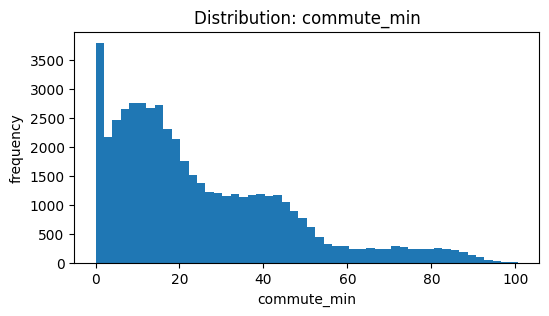

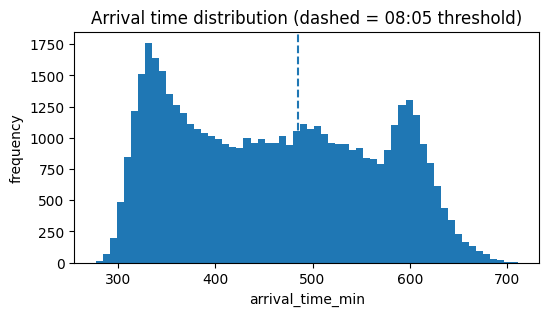

In [38]:
# Section 02: Load dataset and visualize distributions + label balance

if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"CSV not found at {DATASET_PATH}. Put the file in the same folder, or update DATASET_PATH."
    )

df = pd.read_csv(DATASET_PATH)

print("Shape:", df.shape)
display(df.head(10))

print("Late rate (%):", round(df[LABEL].mean() * 100, 2))

assert set(WEEKDAYS).issuperset(set(df["day"].unique())), "Dataset contains non-weekday data."
assert all(col in df.columns for col in FEATURES + [LABEL]), "Missing required columns."

plt.figure(figsize=(5, 3))
df[LABEL].value_counts().sort_index().plot(kind="bar")
plt.title("Class Balance (0=On time, 1=Late)")
plt.xlabel("late")
plt.ylabel("count")
plt.show()

for col in FEATURES:
    plt.figure(figsize=(6, 3))
    plt.hist(df[col], bins=50)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("frequency")
    plt.show()

if "arrival_time_min" in df.columns:
    plt.figure(figsize=(6, 3))
    plt.hist(df["arrival_time_min"], bins=60)
    plt.axvline(LATE_THRESHOLD, linestyle="--")
    plt.title("Arrival time distribution (dashed = 08:05 threshold)")
    plt.xlabel("arrival_time_min")
    plt.ylabel("frequency")
    plt.show()


Section 03 - Train scaled MLP and evaluate

In [39]:
# Section 03: Train an MLP with scaling and evaluate on a held-out test set

X = df[FEATURES].copy()
y = df[LABEL].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)

mlp_model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        alpha=2e-4,
        learning_rate_init=1e-3,
        max_iter=1200,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=25,
        random_state=SEED
    ))
])

mlp_model.fit(X_train, y_train)

proba = mlp_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))

joblib.dump(mlp_model, MODEL_PATH)
print("Saved model:", MODEL_PATH.resolve())


ROC-AUC: 0.9923

Confusion Matrix:
 [[6812  360]
 [ 256 5072]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      7172
           1       0.93      0.95      0.94      5328

    accuracy                           0.95     12500
   macro avg       0.95      0.95      0.95     12500
weighted avg       0.95      0.95      0.95     12500

Saved model: /content/late_mlp_trained_scaled.joblib


Section 04 -Compute model-agnostic feature importance via permutation importance

,0
wake_time_min,0.451833
commute_min,0.029653
prep_min,0.007980
screen_after_wake_min,0.007567
sleep_start_min,0.000127


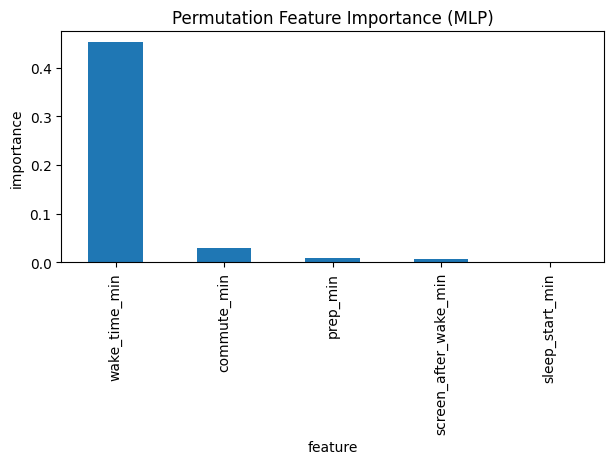

In [40]:
# Section 04: Compute model-agnostic feature importance via permutation importance

pi = permutation_importance(
    mlp_model, X_test, y_test,
    n_repeats=12, random_state=SEED
)

importance = pd.Series(pi.importances_mean, index=FEATURES).sort_values(ascending=False)
display(importance)

plt.figure(figsize=(7, 3))
importance.plot(kind="bar")
plt.title("Permutation Feature Importance (MLP)")
plt.xlabel("feature")
plt.ylabel("importance")
plt.show()


Section 05-Draw a neuron-level architecture diagram for the trained MLP

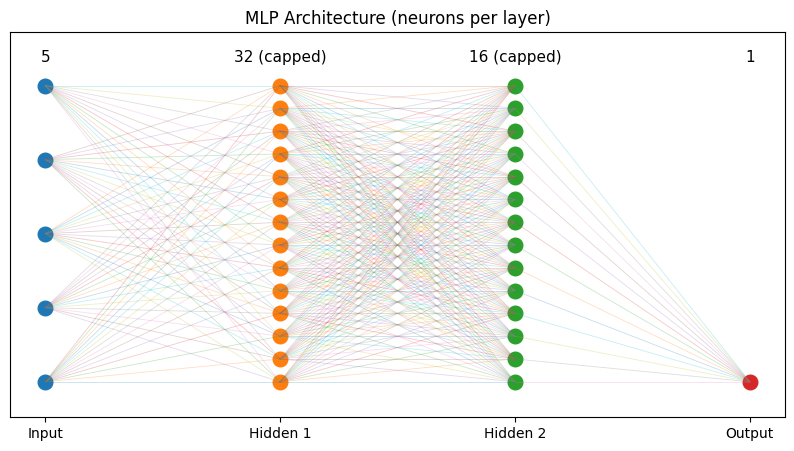

In [41]:
# Section 05: Draw a neuron-level architecture diagram for the trained MLP

def draw_mlp_architecture(input_n, hidden_layers, output_n=1, max_draw=14):
    layers = [input_n] + list(hidden_layers) + [output_n]
    x = np.arange(len(layers))

    plt.figure(figsize=(10, 5))
    for i, n in enumerate(layers):
        shown = min(n, max_draw)
        ys = np.linspace(0, 1, shown)

        plt.scatter([i] * shown, ys, s=110)

        if i < len(layers) - 1:
            n2 = layers[i + 1]
            shown2 = min(n2, max_draw)
            ys2 = np.linspace(0, 1, shown2)

            for y1 in ys:
                for y2 in ys2:
                    plt.plot([i, i + 1], [y1, y2], alpha=0.25, linewidth=0.6)

        label = f"{n}" + (" (capped)" if n > max_draw else "")
        plt.text(i, 1.08, label, ha="center", fontsize=11)

    plt.xticks(x, ["Input"] + [f"Hidden {k+1}" for k in range(len(hidden_layers))] + ["Output"])
    plt.yticks([])
    plt.ylim(-0.12, 1.18)
    plt.title("MLP Architecture (neurons per layer)")
    plt.show()


hidden = mlp_model.named_steps["mlp"].hidden_layer_sizes
if isinstance(hidden, int):
    hidden = (hidden,)

draw_mlp_architecture(input_n=len(FEATURES), hidden_layers=hidden, output_n=1)


Section 06 -Collect yesterday’s habits and infer today (Mon–Fri)

In [42]:
# Section 06: Collect yesterday’s habits and infer today (Mon–Fri)

def ask_day():
    while True:
        s = input("Yesterday was which day? (Mon/Tue/Wed/Thu/Fri): ").strip().title()
        if s in WEEKDAYS:
            return s
        print("Enter one of: Mon Tue Wed Thu Fri")

def ask_time(prompt, default):
    while True:
        s = input(f"{prompt} [default={default}]: ").strip()
        if s == "":
            s = default
        try:
            return hhmm_to_min(s)
        except:
            print("Use HH:MM (24h), e.g., 06:50")

def ask_float(prompt, lo, hi, default):
    while True:
        s = input(f"{prompt} [default={default}]: ").strip()
        if s == "":
            return float(default)
        try:
            v = float(s)
        except:
            print("Enter a number.")
            continue
        if v < lo or v > hi:
            print(f"Must be between {lo} and {hi}.")
            continue
        return float(v)

yesterday_day = ask_day()
print("You need to attend 8 Am class- fill accordingly")

y_wake = ask_time("Yesterday wake-up time (HH:MM)", "06:50")
y_sleep = ask_time("Yesterday sleep start time (HH:MM)", "23:30")
y_screen = ask_float("Yesterday screen time after waking (minutes)", 0, 240, 20)
y_prep = ask_float("Yesterday prep minutes", 6, 90, 25)
y_commute = ask_float("Yesterday commute minutes", 0, 120, 25)

yesterday_features = {
    "wake_time_min": y_wake,
    "sleep_start_min": y_sleep,
    "screen_after_wake_min": y_screen,
    "prep_min": y_prep,
    "commute_min": y_commute
}

print({
    "day": yesterday_day,
    "wake": min_to_hhmm(y_wake),
    "sleep_start": min_to_hhmm(y_sleep),
    "screen_min": y_screen,
    "prep_min": y_prep,
    "commute_min": y_commute
})


Yesterday was which day? (Mon/Tue/Wed/Thu/Fri): Thu
You need to attend 8 Am class- fill accordingly
Yesterday wake-up time (HH:MM) [default=06:50]: 07:00
Yesterday sleep start time (HH:MM) [default=23:30]: 23:00
Yesterday screen time after waking (minutes) [default=20]: 20
Yesterday prep minutes [default=25]: 28
Yesterday commute minutes [default=25]: 30
{'day': 'Thu', 'wake': '07:00', 'sleep_start': '23:00', 'screen_min': 20.0, 'prep_min': 28.0, 'commute_min': 30.0}


Section 07: Forecast probabilities till Friday (or next week if today is Friday),plus what-if curves and an improvement trajectory.

Inferred today: Fri
Forecast: Next week ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']


,period,day,wake,sleep_start,screen_min,prep_min,commute_min,late_probability_pct,prediction
0,Next week,Mon,07:02,23:03,19.6,26.4,31.4,59.4,Late
1,Next week,Tue,07:02,23:27,23.5,26.9,31.5,64.1,Late
2,Next week,Wed,07:01,23:19,23.9,24.4,32.2,58.4,Late
3,Next week,Thu,07:17,23:06,23.2,25.8,30.0,84.6,Late
4,Next week,Fri,07:12,23:15,17.8,24.6,27.0,65.2,Late


,period,day,late_probability_pct,prediction
0,Next week,Mon,58.9,Late
1,Next week,Tue,33.7,On time
2,Next week,Wed,5.2,On time
3,Next week,Thu,1.2,On time
4,Next week,Fri,0.1,On time


,day,baseline_pct,screen_minus_15_pct,prep_minus_10_pct
0,Mon,59.4,44.3,34.7
1,Tue,64.1,49.2,39.7
2,Wed,58.4,42.2,34.9
3,Thu,84.6,76.3,71.5
4,Fri,65.2,49.2,40.8


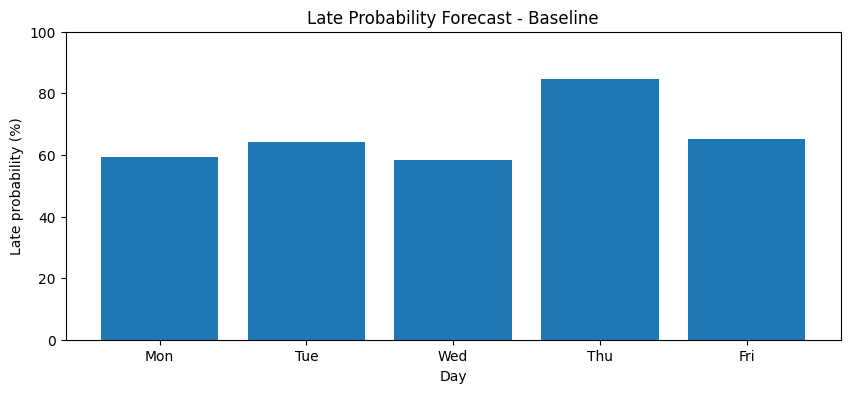

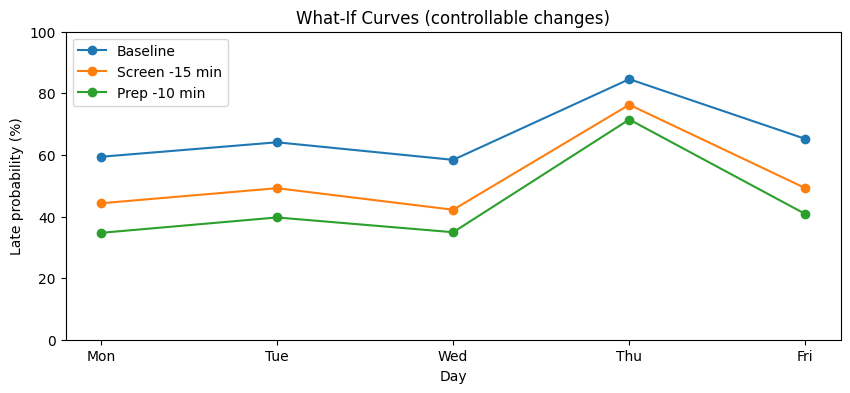

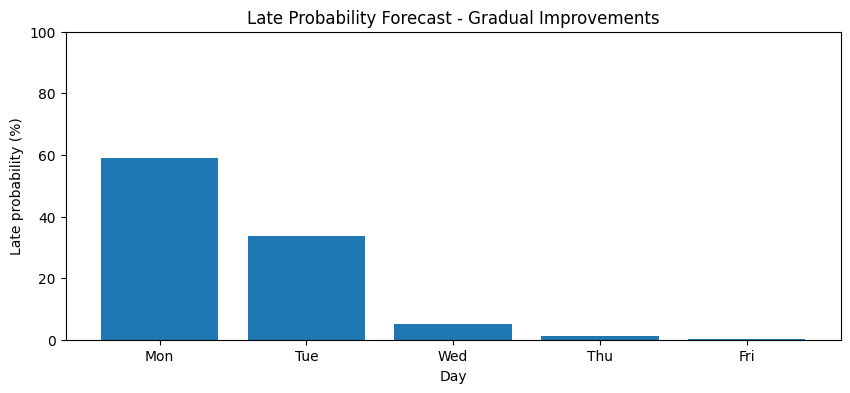

Most influential feature: wake_time_min
Try waking earlier, reducing screen time after waking, and streamlining prep.


In [43]:
# Section 07: Forecast probabilities till Friday (or next week if today is Friday),
# plus what-if curves and an improvement trajectory.

def next_weekday(day):
    i = WEEKDAYS.index(day)
    return WEEKDAYS[(i + 1) % 5]

def remaining_weekdays_from(today):
    i = WEEKDAYS.index(today)
    return WEEKDAYS[i:]

def make_forecast_days(yesterday_day):
    today = next_weekday(yesterday_day)
    if today == "Fri":
        return today, ["Mon", "Tue", "Wed", "Thu", "Fri"], "Next week"
    return today, remaining_weekdays_from(today), "This week"

def predict_prob(feat_dict):
    x = pd.DataFrame([feat_dict], columns=FEATURES)
    return float(mlp_model.predict_proba(x)[0, 1]) * 100

def apply_daily_improvement(feat, frac):
    out = feat.copy()
    out["wake_time_min"] = int(round(out["wake_time_min"] - 20 * frac))
    out["screen_after_wake_min"] = float(max(0, out["screen_after_wake_min"] - 25 * frac))
    out["prep_min"] = float(max(6, out["prep_min"] - 10 * frac))
    out["sleep_start_min"] = int(round((out["sleep_start_min"] - 15 * frac) % (24 * 60)))
    return out

def small_variation(feat, rng_local, scale=1.0):
    out = feat.copy()
    out["wake_time_min"] = int(round(clamp(out["wake_time_min"] + rng_local.normal(0, 5 * scale), 4*60+30, 9*60+30)))
    out["sleep_start_min"] = int(round((out["sleep_start_min"] + rng_local.normal(0, 10 * scale)) % (24 * 60)))
    out["screen_after_wake_min"] = float(clamp(out["screen_after_wake_min"] + rng_local.normal(0, 4 * scale), 0, 240))
    out["prep_min"] = float(clamp(out["prep_min"] + rng_local.normal(0, 2 * scale), 6, 90))
    out["commute_min"] = float(clamp(out["commute_min"] + rng_local.normal(0, 2 * scale), 0, 120))
    return out

today_inferred, forecast_days, period_label = make_forecast_days(yesterday_day)
print("Inferred today:", today_inferred)
print("Forecast:", period_label, forecast_days)

# Baseline path (store day features for fair what-if comparisons)
rng_base = np.random.default_rng(SEED + 999)
baseline_feat_list = []
feat_base = yesterday_features.copy()

for d in forecast_days:
    feat_base = small_variation(feat_base, rng_base, scale=1.0)
    baseline_feat_list.append(feat_base.copy())

baseline_probs = [predict_prob(f) for f in baseline_feat_list]

baseline_df = pd.DataFrame({
    "period": period_label,
    "day": forecast_days,
    "wake": [min_to_hhmm(f["wake_time_min"]) for f in baseline_feat_list],
    "sleep_start": [min_to_hhmm(f["sleep_start_min"]) for f in baseline_feat_list],
    "screen_min": [round(f["screen_after_wake_min"], 1) for f in baseline_feat_list],
    "prep_min": [round(f["prep_min"], 1) for f in baseline_feat_list],
    "commute_min": [round(f["commute_min"], 1) for f in baseline_feat_list],
    "late_probability_pct": np.round(baseline_probs, 1),
    "prediction": ["Late" if p >= 50 else "On time" for p in baseline_probs]
})

display(baseline_df)

# Improvement trajectory (gradual improvements toward last forecast day)
rng_imp = np.random.default_rng(SEED + 2025)
feat_imp = yesterday_features.copy()
n_days = len(forecast_days)

improve_probs = []
for i, d in enumerate(forecast_days):
    frac = 0.0 if n_days == 1 else (i / (n_days - 1))
    feat_imp = small_variation(feat_imp, rng_imp, scale=0.8)
    feat_imp = apply_daily_improvement(feat_imp, frac)
    improve_probs.append(predict_prob(feat_imp))

improve_df = pd.DataFrame({
    "period": period_label,
    "day": forecast_days,
    "late_probability_pct": np.round(improve_probs, 1),
    "prediction": ["Late" if p >= 50 else "On time" for p in improve_probs]
})
display(improve_df)

# What-if curves (starting from baseline daily features)
whatif_screen = []
whatif_prep = []

for f in baseline_feat_list:
    f1 = f.copy()
    f1["screen_after_wake_min"] = max(0.0, f1["screen_after_wake_min"] - 15)
    whatif_screen.append(predict_prob(f1))

    f2 = f.copy()
    f2["prep_min"] = max(6.0, f2["prep_min"] - 10)
    whatif_prep.append(predict_prob(f2))

whatif_df = pd.DataFrame({
    "day": forecast_days,
    "baseline_pct": np.round(baseline_probs, 1),
    "screen_minus_15_pct": np.round(whatif_screen, 1),
    "prep_minus_10_pct": np.round(whatif_prep, 1),
})
display(whatif_df)

plt.figure(figsize=(10, 4))
plt.bar(whatif_df["day"], whatif_df["baseline_pct"])
plt.title("Late Probability Forecast - Baseline")
plt.xlabel("Day")
plt.ylabel("Late probability (%)")
plt.ylim(0, 100)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(whatif_df["day"], whatif_df["baseline_pct"], marker="o", label="Baseline")
plt.plot(whatif_df["day"], whatif_df["screen_minus_15_pct"], marker="o", label="Screen -15 min")
plt.plot(whatif_df["day"], whatif_df["prep_minus_10_pct"], marker="o", label="Prep -10 min")
plt.title("What-If Curves (controllable changes)")
plt.xlabel("Day")
plt.ylabel("Late probability (%)")
plt.ylim(0, 100)
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(improve_df["day"], improve_df["late_probability_pct"])
plt.title("Late Probability Forecast - Gradual Improvements")
plt.xlabel("Day")
plt.ylabel("Late probability (%)")
plt.ylim(0, 100)
plt.show()

top_feature = importance.index[0]
print("Most influential feature:", top_feature)
print("Try waking earlier, reducing screen time after waking, and streamlining prep.")
